In [37]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

try:
  from zoltpy import util, connection
except:
  !pip install pymmwr
  !pip install git+https://github.com/reichlab/zoltpy/
  from zoltpy import util, connection

try:
  from qenspy import qens
except:
  !pip install git+https://github.com/reichlab/qenspy@params
  from qenspy import qens

from numpy.core.arrayprint import format_float_positional
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

In [38]:
# Download example forecast data from Zoltar
os.environ["Z_USERNAME"] = "zoltar_demo"
os.environ["Z_PASSWORD"] = "Dq65&aP0nIlG"
conn = util.authenticate()
project_name = 'COVID-19 Forecasts'

In [39]:
def query_project_forecasts_and_truth(conn, project_name, models, units, targets, timezeros, types):
  """Query forecasts and corresponding observed truth from Zoltar."""
  query = {
    "models": models,
    "units": units,
    "targets": targets,
    "timezeros": timezeros,
    "types": types}
  forecasts = util.query_project(conn, project_name, connection.QueryType.FORECASTS, query) \
    .assign(
      timezero = lambda x: pd.to_datetime(x.timezero),
      forecast_date = lambda x: x.timezero +
        x.timezero.dt.dayofweek.apply(lambda dow: pd.Timedelta(days = dow / 6)),
      value = lambda x: x.value.astype('float64')
    ) \
    [['model', 'unit', 'forecast_date', 'target', 'quantile', 'value']]
  
  query = {
    "units": units,
    "targets": targets,
    "timezeros": timezeros}
  truth = util.query_project(conn, project_name, connection.QueryType.TRUTH, query) \
    .assign(
      timezero = lambda x: pd.to_datetime(x.timezero),
      forecast_date = lambda x: x.timezero +
        x.timezero.dt.dayofweek.apply(lambda dow: pd.Timedelta(days = dow / 6)),
      value = lambda x: x.value.astype('float64')
    ) \
    [['unit', 'forecast_date', 'target', 'value']]
  
  return (forecasts, truth.drop_duplicates())

In [40]:
def q_df_to_array(q_df, tau_strs, models):
  """Convert predictive quantiles from a tidy data frame to a 3d array."""
  q_wide = q_df \
    .set_index(keys = ['unit', 'forecast_date', 'target', 'model', 'quantile']) \
    [['value']] \
    .unstack(['model', 'quantile'])
  model_cols = q_wide.columns.get_level_values(1)
    
  def model_q_ordered(model):
    #print(model)
    df_one_model = q_wide.iloc[:, model_cols == model].droplevel([0, 1], axis = 1)
    missing_cols = np.setdiff1d(tau_strs, df_one_model.columns.values)
    for col_name in missing_cols:
      df_one_model[col_name] = np.NaN
    #print(df_one_model)
    return df_one_model[tau_strs].values
    
  q_arr = np.concatenate(
    [model_q_ordered(model)[..., np.newaxis] for model in models],
    axis = 2
  )
  
  return q_arr

In [41]:
def plot_forecasts(
  q,
  y,
  models,
  tau):
  """Plot observations and predictions."""
  ncols = 3
  nrows = (len(models) + 1)//ncols
  print("nrows = " + str(nrows))
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 4))
  fig.set_tight_layout(True)
  
  interval_colors = ['#a6bddb', '#74a9cf', '#3690c0', '#0570b0']
  interval_labels = ['98%', '95%', '80%', '50%']
  
  for m in range(len(models)):
    row_ind = m // ncols
    col_ind = m % ncols
    
    ax[row_ind, col_ind].grid()
    ax[row_ind, col_ind].set_axisbelow(True)
    ax[row_ind, col_ind].set(
      xticks=np.linspace(1, 4, 4),
      xlabel='Forecast Horizon',
      ylabel='',
      title=models[m])
    #ax[row_ind, col_ind].yaxis.set_major_formatter(mtick.StrMethodFormatter('{:s}')) #%8d
    ax[row_ind, col_ind].yaxis.set_major_formatter(mtick.FormatStrFormatter('%8d')) #
    #ax[row_ind, col_ind].text(0,1,models[m],ha='right',va='top',transform=ax[row_ind, col_ind].transAxes,weight='bold')
    
    # Prediction intervals
    for interval_ind, half_alpha in enumerate([0.01, 0.025, 0.1, 0.25]):
      k_lower = np.where(abs(tau - half_alpha) < 1e-7)
      k_upper = np.where(abs(tau - (1 - half_alpha)) < 1e-7)
      ax[row_ind, col_ind].fill_between(
        np.linspace(1, 4, 4),
        q[:, k_lower, m].reshape(4),
        q[:, k_upper, m].reshape(4),
        color = interval_colors[interval_ind],
        label = interval_labels[interval_ind])
    
    # train set data
    ax[row_ind, col_ind].plot(
        np.linspace(1, 4, 4),
        y,
        'orange',
        label = "Observed")
    
    # plot predictive median
    k_median = np.where(abs(tau - 0.5) < 1e-7)
    ax[row_ind, col_ind].plot(
        np.linspace(1, 4, 4),
        q[:, k_median, m].reshape(4),
        '#034e7b',
        ls='--',
        lw=3.0,
        label = "Forecast")
    
    if m == 0:
      ax[row_ind, col_ind].legend(loc='upper right', ncol=3)
  
  plt.show()

In [42]:
# load forecasts and data from Zoltar
models = ["epiforecasts-ensemble1", "LNQ-ens1", "UMass-MechBayes"]
models = ['AIpert-pwllnod', 'BPagano-RtDriven', 'CEID-Walk', 'CMU-TimeSeries', 'Columbia_UNC-SurvCon', 'Covid19Sim-Simulator', 'CovidAnalytics-DELPHI', 'COVIDhub-baseline', 'CU-select', 'epiforecasts-ensemble1', 'Geneva-DetGrowth', 'Google_Harvard-CPF', 'IHME-CurveFit', 'IowaStateLW-STEM', 'JHU_CSSE-DECOM', 'JHU_IDD-CovidSP', 'JHUAPL-Bucky', 'Karlen-pypm', 'LANL-GrowthRate', 'LNQ-ens1', 'Microsoft-DeepSTIA', 'MIT_CritData-GBCF', 'MIT_ISOLAT-Mixtures', 'MOBS-GLEAM_COVID', 'OliverWyman-Navigator', 'PSI-DRAFT', 'RobertWalraven-ESG', 'RPI_UW-Mob_Collision', 'SigSci-TS', 'TTU-squider', 'UA-EpiCovDA', 'UCSD_NEU-DeepGLEAM', 'UMass-MechBayes', 'UMich-RidgeTfReg', 'USC-SI_kJalpha']
train_units = ['US', '01', '02', '04', '05', '06', '08', '09', '10', '11', '12', '13', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48', '49', '50', '51', '53', '54', '55', '56', '60', '66', '69', '72', '74', '78']
test_units = ["39"]
targets = [str(h + 1) + ' wk ahead inc death' for h in range(4)]
types = ["quantile"]
train_timezeros = [
  '2021-01-03', '2021-01-04', '2021-01-10', '2021-01-11',
  '2021-01-17', '2021-01-18', '2021-01-24', '2021-01-25',
  '2021-01-31', '2021-02-01', '2021-02-07', '2021-02-08']
test_timezeros = ['2021-02-14', '2021-02-15']

In [43]:
tau_strs = ['0.01', '0.025']
tau_strs.extend(
  [np.format_float_positional(x, 2) for x in np.linspace(0.05, 0.95, 19)])
tau_strs.extend(['0.975', '0.99'])
tau = tf.constant(np.array(tau_strs).astype('float64'))


In [44]:
(train_forecasts, train_truth) = query_project_forecasts_and_truth(
  conn=conn,
  project_name=project_name,
  models=models,
  units=train_units,
  targets=targets,
  timezeros=train_timezeros,
  types=types)


* polling for status change. job: ('Job', 'https://zoltardata.com/api/job/53207/', 53207)
- QUEUED
- QUEUED
- QUEUED


KeyboardInterrupt: 

In [8]:
(test_forecasts, test_truth) = query_project_forecasts_and_truth(
  conn=conn,
  project_name=project_name,
  models=models,
  units=test_units,
  targets=targets,
  timezeros=test_timezeros,
  types=types)



* polling for status change. job: ('Job', 'https://zoltardata.com/api/job/53204/', 53204)
- QUEUED
- SUCCESS

* polling for status change. job: ('Job', 'https://zoltardata.com/api/job/53205/', 53205)
- QUEUED
- SUCCESS


In [9]:
q_train = tf.constant(q_df_to_array(train_forecasts, tau_strs, models))
y_train = tf.constant(train_truth['value'].values)

q_test = tf.constant(q_df_to_array(test_forecasts, tau_strs, models))
y_test = tf.constant(test_truth['value'].values)

In [17]:
q_train[:, :, 17]

<tf.Tensor: shape=(1368, 23), dtype=float64, numpy=
array([[  170. ,   184. ,   200.8, ...,   511. ,   557. ,   588. ],
       [  167. ,   185. ,   203. , ...,   608. ,   687. ,   723. ],
       [  157. ,   187.9,   209. , ...,   724.1,   790.3,   870. ],
       ...,
       [11571.9, 11990.2, 12446.6, ..., 17388.9, 18110.5, 18782.2],
       [ 9271.1,  9743.6, 10215.6, ..., 15063.9, 15888.1, 16438.6],
       [ 7483.2,  7909.3,  8294.8, ..., 12919.9, 13702.9, 14330. ]])>

In [19]:
q_df = train_forecasts

"""Convert predictive quantiles from a tidy data frame to a 3d array."""
q_wide = q_df \
    .set_index(keys = ['unit', 'forecast_date', 'target', 'model', 'quantile']) \
    [['value']] \
    .unstack(['model', 'quantile'])
model_cols = q_wide.columns.get_level_values(1)
    
def model_q_ordered(model):
    #print(model)
    df_one_model = q_wide.iloc[:, model_cols == model].droplevel([0, 1], axis = 1)
    missing_cols = np.setdiff1d(tau_strs, df_one_model.columns.values)
    for col_name in missing_cols:
        df_one_model[col_name] = np.NaN
    #print(df_one_model)
    return df_one_model[tau_strs].values

# q_arr = np.concatenate(
#     [model_q_ordered(model)[..., np.newaxis] for model in models],
#     axis = 2
# )
model_q_ordered('Karlen-pypm')[..., np.newaxis].shape

(1368, 23, 1)

In [11]:
# illustrate calculation of equal-weighted mean ensemble
K = len(tau)
M = len(models)

w_equal = tf.constant(np.full((K, M), 1./M))
q_equal_mean = qens.MeanQEns().predict(q_test, w={'w': w_equal})

In [12]:
# fit a weighted mean ensemble
tau_groups = np.zeros(len(tau))
init_param_vec = tf.constant(np.zeros(34))

meanqens = qens.MeanQEns()
meanqens.fit(y_train, q_train, tau, tau_groups, init_param_vec, optim_method="sgd", num_iter=10000, learning_rate=0.1, verbose = True)

47992134e-05,
       -1.91087138e-03,  9.48905001e-05,  1.10152199e-04,  9.17825677e-05,
        7.54383120e-05,  6.93719980e-05,  1.67794525e-04,  8.22033711e-05,
        8.09384384e-05,  4.69063686e-05, -9.04492091e-04,  8.92959805e-05,
        8.98639007e-05,  9.43741399e-25,  8.92908412e-05,  8.23124180e-05,
        1.62267318e-04,  6.88849459e-05])>]
9985
param estimates vec = 
[-5.84750267e-01 -7.67804174e-01 -1.05449292e+00 -9.10522664e-01
 -1.79116371e+00 -1.45046225e+00  2.26849831e+00 -1.50371092e+00
  3.72693924e-01 -2.39942138e-01  8.63771915e-17  8.63771915e-17
  8.63771915e-17 -1.98778459e+00 -7.68780172e-01 -6.92728587e-01
  2.02432038e+01 -5.12430406e-01 -1.47576044e+00  6.21389638e-01
 -2.10192402e+00 -2.05372036e+00 -2.60869297e-01 -1.55118770e+00
 -1.75600131e+00 -1.20197537e+00  1.00687264e+01 -2.25494359e+00
 -3.88640314e-01  8.63771915e-17 -1.06865558e+00 -1.57688890e+00
 -6.54010559e-02 -2.19217256e+00]
loss = 
440.05198093907046
grads = 
[<tf.Tensor: shape=(34,)

In [39]:
# the estimated weights
meanqens.unpack_params(meanqens.get_param_estimates_vec(), M, tau_groups)

{'w': <tf.Tensor: shape=(23, 35), dtype=float64, numpy=
 array([[3.43245225e-14, 6.11856804e-14, 2.14652323e-14, 1.81379437e-14,
         1.20847215e-14, 6.27793187e-14, 1.47657523e-08, 2.68665361e-14,
         5.40973570e-13, 1.26341046e-13, 3.15904130e-12, 3.15904130e-12,
         3.15904130e-12, 3.32733034e-14, 2.85538558e-14, 6.02914331e-14,
         9.99999096e-01, 9.29371933e-14, 2.29544050e-14, 5.24639197e-13,
         2.88366643e-14, 3.50105876e-14, 9.67970447e-14, 1.85538039e-14,
         2.43203010e-14, 7.14743577e-14, 8.89068231e-07, 1.65705132e-14,
         9.63410241e-14, 3.15904130e-12, 4.12410580e-14, 1.82625177e-14,
         1.81207097e-13, 3.79763143e-14, 3.15904130e-12],
        [3.43245225e-14, 6.11856804e-14, 2.14652323e-14, 1.81379437e-14,
         1.20847215e-14, 6.27793187e-14, 1.47657523e-08, 2.68665361e-14,
         5.40973570e-13, 1.26341046e-13, 3.15904130e-12, 3.15904130e-12,
         3.15904130e-12, 3.32733034e-14, 2.85538558e-14, 6.02914331e-14,
         9

In [20]:
# illustrate calculation of unequal-weighted mean ensemble predictions
q_weighted_mean = meanqens.predict(
    q_test,
    w=meanqens.unpack_params(meanqens.get_param_estimates_vec(), M, tau_groups))

In [86]:
q_model16 = q_train[:, :, 16]
to_keep16 = (np.sum(np.isnan(q_model16.numpy()), axis = 1) == 0)
q_model17 = q_train[:, :, 17]
to_keep17 = (np.sum(np.isnan(q_model17.numpy()), axis = 1) == 0)
to_keep = np.logical_and(to_keep16, to_keep17)

q_model16 = tf.constant(q_model16.numpy()[to_keep, :])
q_model17 = tf.constant(q_model17.numpy()[to_keep, :])

In [87]:
meanqens.pinball_loss(y_train[to_keep], q_model16, tau)

<tf.Tensor: shape=(), dtype=float64, numpy=476.33271735570224>

In [88]:
meanqens.pinball_loss(y_train[to_keep], q_model17, tau)

<tf.Tensor: shape=(), dtype=float64, numpy=518.5237728465956>

In [79]:
q_model.shape

TensorShape([1140, 23])

In [67]:
import tensorflow_addons as tfa

In [90]:
np.mean([tfa.losses.pinball_loss(y_train[to_keep], q_model17[:, k], tau[k]).numpy() for k in range(23)])

518.5237728465955

In [22]:
# fit a weighted mean ensemble
tau_groups = np.zeros(len(tau))
init_param_vec = tf.constant(np.zeros(34))

medianqens = qens.MedianQEns(bw_method="silverman_weighted")
medianqens.fit(y_train, q_train, tau, tau_groups, init_param_vec, optim_method="adam", num_iter=100, learning_rate=0.1, verbose = True)

22e-02,  6.03700988e-03,
        1.01044835e-01, -1.94439840e-17,  3.29360647e-03,  3.81585764e-03,
       -1.09431021e-01,  5.14649340e-03])>]
83
param estimates vec = 
[-2.64634718  0.60040857  0.65531795  0.60040857 -0.60040857 -0.60040857
  4.68217874  0.59027397  4.27774046  0.59027397  0.17255467  0.17255467
  0.17255467 -2.61407502 -0.58037869  0.62217262 -0.48325957  0.60040857
 -0.63165051 -0.60040857 -2.61876138 -2.62892487  3.97535429 -2.95945942
 -2.80049116 -0.61001578  0.63090139 -2.60761692  2.03521045  0.17255467
 -0.84762315 -2.79032273  0.57037663 -2.5662237 ]
loss = 
461.37234475786767
grads = 
[<tf.Tensor: shape=(34,), dtype=float64, numpy=
array([ 3.52882120e-04,  3.28625123e-03,  2.20563559e-02, -5.32449872e-02,
        2.28399407e-02,  2.90102056e-02, -1.89890288e+00,  2.81207816e-02,
        8.13221771e-01, -8.31560688e-02,  3.07968853e-19,  3.07968853e-19,
        3.07968853e-19,  1.05232492e-03,  2.33043342e-03, -2.18590525e-02,
       -1.03469218e-02, -2.4415

In [23]:
medianqens.get_param_estimates_vec()

array([-2.67320776,  0.60052208,  0.65544393,  0.60052208, -0.60052208,
       -0.60052208,  4.76804651,  0.59038519,  4.48241302,  0.59038519,
        0.17258627,  0.17258627,  0.17258627, -2.63188078, -0.58048766,
        0.62229108, -0.48334651,  0.60052208, -0.63177111, -0.60052208,
       -2.64163704, -2.65468195,  3.66036884, -2.98825232, -2.82085196,
       -0.61013148,  0.63102182, -2.65582842,  1.85651715,  0.17258627,
       -0.87433936, -2.8130841 ,  0.57048333, -2.58719651])

In [24]:
medianqens.unpack_params(medianqens.get_param_estimates_vec(), M, tau_groups)

{'w': <tf.Tensor: shape=(23, 35), dtype=float64, numpy=
 array([[2.47779803e-04, 6.54378031e-03, 6.91322934e-03, 6.54378031e-03,
         1.96889183e-03, 1.96889183e-03, 4.22436635e-01, 6.47778176e-03,
         3.17477186e-01, 6.47778176e-03, 4.26558448e-03, 4.26558448e-03,
         4.26558448e-03, 2.58234335e-04, 2.00873522e-03, 6.68779366e-03,
         2.21365818e-03, 6.54378031e-03, 1.90831724e-03, 1.96889183e-03,
         2.55727184e-04, 2.52412908e-04, 1.39541463e-01, 1.80818886e-04,
         2.13769059e-04, 1.95006258e-03, 6.74643870e-03, 2.52123691e-04,
         2.29773763e-02, 4.26558448e-03, 1.49728518e-03, 2.15436051e-04,
         6.35013631e-03, 2.70035035e-04, 3.58942831e-03],
        [2.47779803e-04, 6.54378031e-03, 6.91322934e-03, 6.54378031e-03,
         1.96889183e-03, 1.96889183e-03, 4.22436635e-01, 6.47778176e-03,
         3.17477186e-01, 6.47778176e-03, 4.26558448e-03, 4.26558448e-03,
         4.26558448e-03, 2.58234335e-04, 2.00873522e-03, 6.68779366e-03,
         2

In [25]:
# illustrate calculation of unequal-weighted mean ensemble predictions
q_weighted_median = medianqens.predict(
    q_test,
    w=medianqens.unpack_params(medianqens.get_param_estimates_vec(), M, tau_groups))

nrows = 13


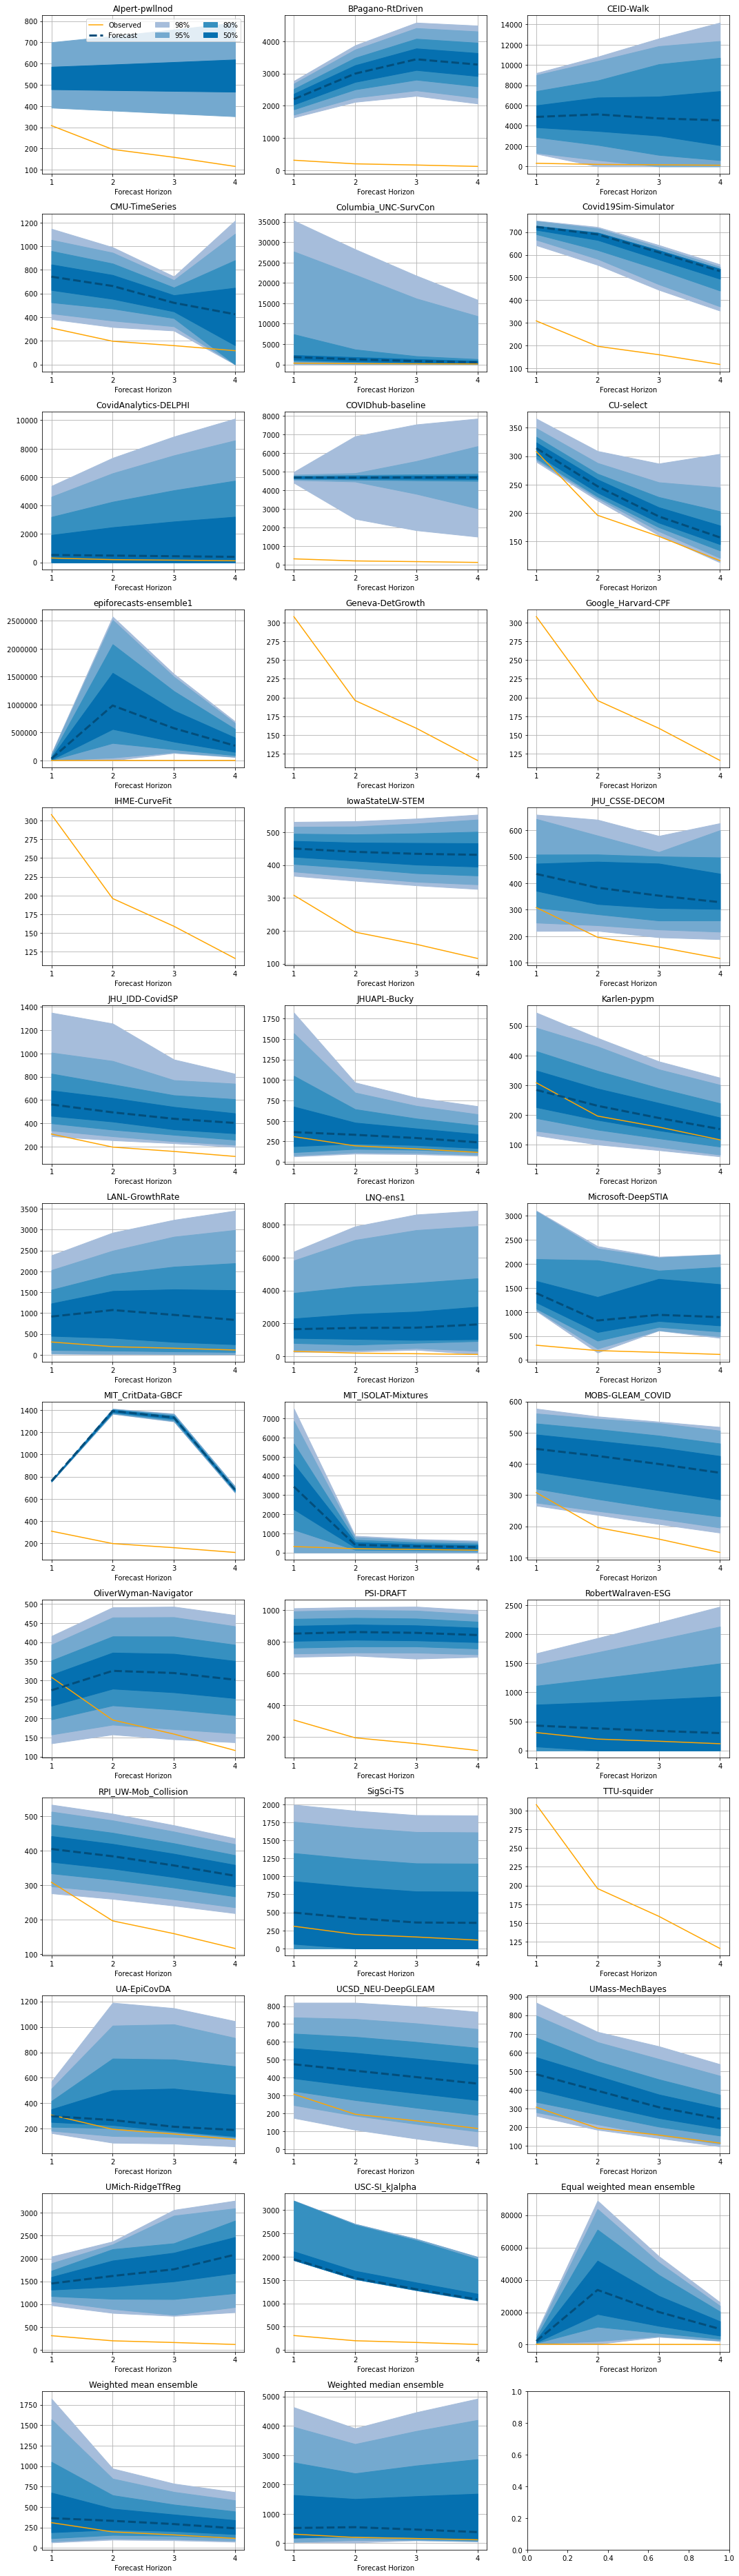

In [36]:
# make a plot
q_combined = np.concatenate([q_test, q_equal_mean[..., np.newaxis], q_weighted_mean[..., np.newaxis], q_weighted_median[..., np.newaxis]], axis = 2)
models_combined = models.copy()
models_combined.append('Equal weighted mean ensemble')
models_combined.append('Weighted mean ensemble')
models_combined.append('Weighted median ensemble')

plot_forecasts(
  q = q_combined,
  y = y_test,
  models = models_combined,
  tau = tau)